In [ ]:
!git clone https://github.com/LikhanBiswas/deepfakehub
!pip install efficientnet-pytorch
!pip install -q keras
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd deepfakehub/notebook/

Cloning into 'deepfakehub'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 268 (delta 21), reused 0 (delta 0), pack-reused 227
Receiving objects: 100% (268/268), 78.59 MiB | 51.09 MiB/s, done.
Resolving deltas: 100% (79/79), done.
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-9u3com4_
/content/deepfakehub/notebook/deepfakehub/notebook


In [ ]:
import torch
import keras
import os
import glob
import easydict
from torch.utils.model_zoo import load_url
from torchvision.transforms import ToPILImage
from PIL import Image, ImageChops
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

## Load images

In [ ]:
im_real = Image.open('samples/khalisi.png')
im_fake = Image.open('samples/0.png')

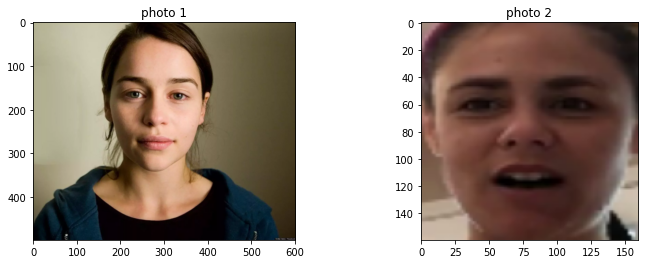

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].imshow(im_real)
ax[0].set_title('photo 1')

ax[1].imshow(im_fake)
ax[1].set_title('photo 2');

## Extract faces

In [ ]:
im_real_faces = face_extractor.process_image(img=im_real)
im_fake_faces = face_extractor.process_image(img=im_fake)

In [ ]:
im_real_face = im_real_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
im_fake_face = im_fake_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace

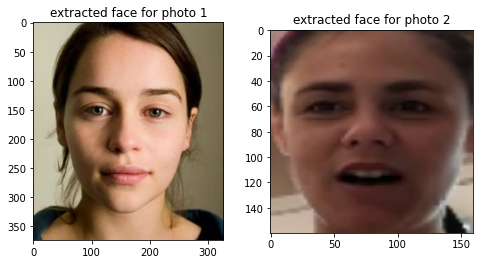

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('extracted face for photo 1')

ax[1].imshow(im_fake_face)
ax[1].set_title('extracted face for photo 2');

## Predict scores

In [ ]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )

with torch.no_grad():
    faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()

In [ ]:
"""
Print scores.
A score close to 0 predicts REAL. A score close to 1 predicts FAKE.
"""
print('Probability for photo 1 face: {:.4f}'.format(faces_pred[0]))
print('Probability for photo 2 face: {:.4f}'.format(faces_pred[1]))

Probability for photo 1 face: 0.0004
Probability for photo 2 face: 0.8732


In [ ]:
if (0<faces_pred[0]<0.5):
  print("Photo 1 is REAL")
else:
  print("Photo 1 is FAKE")

if (0<faces_pred[1]<0.5):
   print("Photo 2 is REAL")
else:
   print("Photo 2 is FAKE") 


Photo 1 is REAL
Photo 2 is FAKE


attention

In [ ]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )

with torch.no_grad():
    if hasattr(net,'feat_ext'):
        atts = net.feat_ext.get_attention(faces_t.to(device)).cpu()
    else:
        atts = net.get_attention(faces_t.to(device)).cpu()

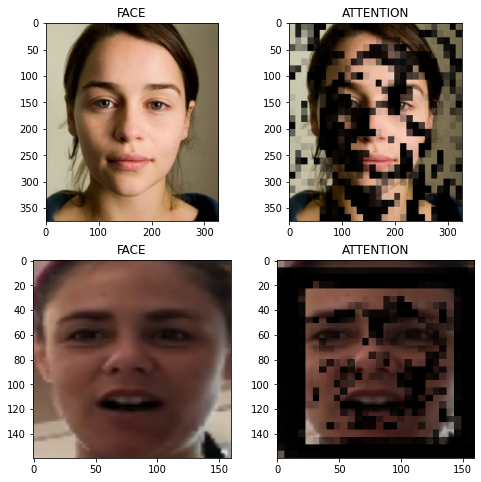

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(8,8))

for idx, (face_t, att) in enumerate(zip([im_real_face,im_fake_face], atts)):
    face_im = ToPILImage()(face_t)
    att_img = ToPILImage()(att)
    att_img = att_img.resize(face_im.size, resample=Image.NEAREST).convert('RGB')
    face_att_img = ImageChops.multiply(face_im, att_img)
    
    ax[idx, 0].imshow(face_im)
    ax[idx, 0].set_title('FACE')
    ax[idx, 1].imshow(face_att_img)
    ax[idx, 1].set_title('ATTENTION')